In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image as Image
import os
import math

In [2]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter


In [3]:
from model import Unet

In [4]:
class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=2, alpha=1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        BCE_loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return torch.mean(focal_loss)

In [11]:
class SoftDiceLoss(torch.nn.Module):
    def __init__(self, epsilon=1e-6):
        super(SoftDiceLoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, inputs, targets):
        # Calculate intersection and union for each sample in the batch
        inputs = torch.sigmoid(inputs)
        intersection = torch.sum(inputs * targets, dim=(1, 2, 3))  # Sum over height, width, and channels
        total = torch.sum(inputs, dim=(1, 2, 3)) + torch.sum(targets, dim=(1, 2, 3))
        
        # Calculate Dice coefficient with epsilon for numerical stability
        dice_coefficient = (2. * intersection + self.epsilon) / (total + self.epsilon)
        
        # Calculate Dice Loss for each sample in the batch
        dice_loss = 1 - dice_coefficient
        
        # Calculate the average loss over the batch
        dice_loss = torch.mean(dice_loss)
        
        return dice_loss

In [6]:
class SegData(Dataset):

    def __init__(self,image_paths,mask_paths,img_mean,img_std,transform = None):
        super().__init__()
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.img_mean = img_mean
        self.img_std = img_std

    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        
        image = Image.open(self.image_paths[index]).convert('RGB')
        mask = Image.open(self.mask_paths[index]).convert('L')

        image = np.array(image)
        mask = np.array(mask)

        image = np.transpose(image,(2,0,1))

        image = torch.from_numpy(image).to(torch.float32)
        mask = torch.from_numpy(mask).to(torch.long)

        image = torch.unsqueeze(image,0)
        mask = torch.unsqueeze(torch.unsqueeze(mask,dim=0),dim=0)
        
        basic_image_transform = transforms.Compose(transforms=[
            transforms.Resize(size = (256,256)),
            transforms.Normalize(mean = self.img_mean,std = self.img_std),
        ])

        basic_mask_transform = transforms.Compose(transforms=[
            transforms.Resize(size = (256,256)),
            transforms.Lambda(lambda x: x/torch.max(x)),
        ])

        image = basic_image_transform(image)
        mask = basic_mask_transform(mask)

        image = image.squeeze()
        mask = mask.squeeze()

        if self.transform:

            image = self.transform(image)
            mask = self.transform(mask)
        
        sample = {'image':image,'mask':mask}

        return sample

In [7]:
data_dir = '/home/UFAD/s.kapoor/GrainGrowth/skapoor/dl_mis/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset'
data_fold = [x.name for x in os.scandir(data_dir) if x.is_dir()]
data_fold.remove('.ipynb_checkpoints')

total_input_files = []
total_output_files = []
for fold in data_fold:
    fold_dir = os.path.join(data_dir,fold)
    for subfold in [x.name for x in os.scandir(os.path.join(data_dir,fold)) if (x.is_dir and x.name[0]!='.' and x.name!='Thumbs.db')]:
        subfold_dir = os.path.join(fold_dir,subfold)
        if subfold == 'images':
            total_input_files.extend([os.path.join(subfold_dir,img_name) for img_name in os.listdir(os.path.join(fold_dir,subfold)) if img_name!='Thumbs.db'])
        elif subfold == 'masks':
            total_output_files.extend([os.path.join(subfold_dir,img_name) for img_name in os.listdir(os.path.join(fold_dir,subfold)) if img_name!='Thumbs.db'])

In [8]:
# h_img,w_img = Image.open(total_input_files[0]).convert('RGB').size
# #get normalization values for the complete dataset
# red_sum = 0
# # blue_sum = 0
# # green_sum = 0
# # because orignal data is grey scale so values are distributed evenly across all three channels.
# for files in total_input_files:

#     pil_image = Image.open(files).convert('RGB')
#     np_image = np.array(pil_image)

#     red_values = np_image[:,:,0].flatten()
#     # green_values = np_image[:,:,1].flatten()
#     # blue_values = np_image[:,:,2].flatten()

#     red_sum += np.sum(red_values)
#     # blue_sum += np.sum(blue_values)
#     # green_sum += np.sum(green_values)

#     del(red_values)
#     # del(green_values)
#     # del(blue_values)

# total_mean = [red_sum/(h_img*w_img*len(total_input_files))]*3

# red_std_sum = 0
# for files in total_input_files:

#     pil_image = Image.open(files).convert('RGB')
#     np_image = np.array(pil_image)

#     red_values = (np_image[:,:,0].flatten() - total_mean[0])**2
#     red_std_sum += np.sum(red_values)

#     del(red_values)

# total_std = [math.sqrt(red_std_sum/(h_img*w_img*len(total_input_files)))]*3

In [9]:
from tqdm import tqdm

In [10]:
import gc

In [12]:
def train():

    seed = 13
    torch.manual_seed(seed)
    best_v_loss = 1_000_000

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:3" if use_cuda else "cpu")
    
    model = Unet(3,1)
    model.to(device)
    epochs = 10
    loss_func = SoftDiceLoss()
    loss_func.to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer,factor = 0.8,min_lr=1e-6)
    pth = os.getcwd()
    model_path = os.path.join(pth,'model_3_soft_dice_loss')
    log_dir = os.path.join(model_path,'runs')
    wts_path = os.path.join(model_path,'weigths')

    if os.path.exists(model_path) == False:
        os.mkdir(model_path)
        
        os.mkdir(log_dir)
        
        os.mkdir(wts_path)
    
    writer = SummaryWriter(log_dir=log_dir)

    #splitting the dataset into traininig and validation set
    train_img,valid_img,train_mask,valid_mask = train_test_split(total_input_files,total_output_files,test_size=0.2,random_state=seed)
    train_data = SegData(image_paths = train_img,mask_paths=train_mask,img_mean=[129.908, 129.908, 129.908],img_std=[64.484, 64.484, 64.484])
    valid_data = SegData(image_paths = valid_img,mask_paths=valid_mask,img_mean=[129.908, 129.908, 129.908],img_std=[64.484, 64.484, 64.484])
    train_dataloader = DataLoader(train_data,batch_size = 4,shuffle = True,pin_memory = True)
    valid_dataloader = DataLoader(valid_data,batch_size = 4,shuffle = False,pin_memory = True)
    patience = 5
    counter = 0

    #print("After Model to device : ",torch.cuda.memory_allocated(device)/(1024*1024))
    for e in tqdm(range(epochs)):

        #training the model 
        print('Epoch {0}'.format(e+1))
        epoch_loss = 0.0
        run_loss = 0.0
        model.train(True)

        for i,batch in enumerate(train_dataloader):
            
            image = batch['image'].to(device)
            mask = batch['mask'].to(device)
    
            #print(batch['image'].shape)
            v_img = transforms.RandomVerticalFlip(p=1)(image)
            h_img = transforms.RandomHorizontalFlip(p=1)(image)
            r_img = transforms.RandomRotation(degrees=(-25,25))(image)
            image_final = torch.cat((image,v_img,h_img,r_img),0)

            #print(image_final.shape)
                    
            v_mask = transforms.RandomVerticalFlip(p=1)(mask)
            h_mask = transforms.RandomHorizontalFlip(p=1)(mask)
            r_mask = transforms.RandomRotation(degrees=(-25,25))(mask)
            mask_final = torch.cat((mask,v_mask,h_mask,r_mask),0)
            mask_final = torch.unsqueeze(mask_final,1)
            #print(mask_final.shape)
            
#             image_final.to(device)
#             mask_final.to(device)
            
#             print(image_final.dtype)
#             print(mask_final.dtype)
#             print(device)
            #a = torch.cuda.memory_allocated(device)/(1024*1024)
            optimizer.zero_grad()
            pred = model.forward(image_final)
            #print("after forward pass", torch.cuda.memory_allocated(device)/(1024*1024))
            #b = torch.cuda.memory_allocated(device)/(1024*1024)
            #print("memory consumed by forward_pass",b-a)
            loss = loss_func(pred,mask_final)
            

            run_loss = run_loss + loss.item()
            epoch_loss = epoch_loss + loss.item()
            
            loss.backward()
            #print("memory after backward pass ", torch.cuda.memory_allocated(device)/(1024*1024))
            optimizer.step()
            #print("memory after optimizer ",torch.cuda.memory_allocated(device)/(1024*1024))

            #print('the current loss is {0}'.format(run_loss))
            
#             del mask_final
#             del image_final
#             del pred
#             del v_img
#             del h_img
#             del r_img
#             del v_mask
#             del h_mask
#             del r_mask
#             del mask
#             del image
            
            #print("memory after delete ",torch.cuda.memory_allocated(device)/(1024*1024))
            

            if(i%100 == 99):
                
#                 for obj in gc.get_objects():
#                     try:
#                         if torch.is_tensor(obj) or (hasattr(obj,'data') and torch.is_tensor(obg.data)):
#                             print(type(obj),obj.size())
#                     except:
#                         pass
                

                print("\tBatch Loss for curent for {0} is {1:.5f}".format(i,run_loss/100))
                run_loss = 0.0
                

        avg_e_loss = epoch_loss/(i+1)
        print('The average loss for the epoch is {0}'.format(avg_e_loss))

        #validating the model
        model.train(False)

        val_loss = 0.0

        for k,batch in enumerate(valid_dataloader):
            final_image = batch['image'].to(device)
            final_mask = torch.unsqueeze(batch['mask'],1).to(device)

            pred = model.forward(final_image)
            loss = loss_func(pred,final_mask)

            val_loss+= loss.item()
            
#             del final_image
#             del final_mask
#             break
        
        

        avg_val_loss = val_loss/(k+1)
        print('The average validation loss for the epoch is {0:.5f}'.format(avg_val_loss))
        writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_e_loss, 'Validation' : avg_val_loss },
                    e)
        counter+=1
        if avg_val_loss < best_v_loss:

            best_v_loss = avg_val_loss
            best_wt_path = os.path.join(wts_path,'best_epoch'+str(e))
            counter = 0
        
        writer.flush()
        

        #break
        wt_path =  os.path.join(wts_path,'epoch_'+str(e))
        torch.save(model.state_dict(), wt_path)
        
        if counter>= patience:
            print('Early stopping after epoch {0}'.format(e))
            
    torch.save(model.state_dict(), best_wt_path)

In [13]:
train()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1
	Batch Loss for curent for 99 is 0.39036
	Batch Loss for curent for 199 is 0.20598
	Batch Loss for curent for 299 is 0.18085
	Batch Loss for curent for 399 is 0.15112
	Batch Loss for curent for 499 is 0.15544
	Batch Loss for curent for 599 is 0.13714
	Batch Loss for curent for 699 is 0.12014
	Batch Loss for curent for 799 is 0.10695
	Batch Loss for curent for 899 is 0.10940
	Batch Loss for curent for 999 is 0.11419
	Batch Loss for curent for 1099 is 0.10566
	Batch Loss for curent for 1199 is 0.09809
	Batch Loss for curent for 1299 is 0.10199
	Batch Loss for curent for 1399 is 0.10633
	Batch Loss for curent for 1499 is 0.09999
	Batch Loss for curent for 1599 is 0.09869
	Batch Loss for curent for 1699 is 0.08940
	Batch Loss for curent for 1799 is 0.08937
	Batch Loss for curent for 1899 is 0.08942
	Batch Loss for curent for 1999 is 0.09195
	Batch Loss for curent for 2099 is 0.08894
	Batch Loss for curent for 2199 is 0.08693
	Batch Loss for curent for 2299 is 0.09454
	Batch Loss fo

 10%|█         | 1/10 [30:42<4:36:25, 1842.79s/it]

Epoch 2
	Batch Loss for curent for 99 is 0.07471
	Batch Loss for curent for 199 is 0.07384
	Batch Loss for curent for 299 is 0.07844
	Batch Loss for curent for 399 is 0.07402
	Batch Loss for curent for 499 is 0.07718
	Batch Loss for curent for 599 is 0.07889
	Batch Loss for curent for 699 is 0.07923
	Batch Loss for curent for 799 is 0.07189
	Batch Loss for curent for 899 is 0.08009
	Batch Loss for curent for 999 is 0.08009
	Batch Loss for curent for 1099 is 0.07651
	Batch Loss for curent for 1199 is 0.07226
	Batch Loss for curent for 1299 is 0.07527
	Batch Loss for curent for 1399 is 0.08019
	Batch Loss for curent for 1499 is 0.08018
	Batch Loss for curent for 1599 is 0.07881
	Batch Loss for curent for 1699 is 0.06979
	Batch Loss for curent for 1799 is 0.07366
	Batch Loss for curent for 1899 is 0.07318
	Batch Loss for curent for 1999 is 0.07335
	Batch Loss for curent for 2099 is 0.07443
	Batch Loss for curent for 2199 is 0.07086
	Batch Loss for curent for 2299 is 0.07426
	Batch Loss fo

 20%|██        | 2/10 [1:01:22<4:05:28, 1841.12s/it]

Epoch 3
	Batch Loss for curent for 99 is 0.06791
	Batch Loss for curent for 199 is 0.07074
	Batch Loss for curent for 299 is 0.06708
	Batch Loss for curent for 399 is 0.07020
	Batch Loss for curent for 499 is 0.06459
	Batch Loss for curent for 599 is 0.07031
	Batch Loss for curent for 699 is 0.07139
	Batch Loss for curent for 799 is 0.06611
	Batch Loss for curent for 899 is 0.06819
	Batch Loss for curent for 999 is 0.07059
	Batch Loss for curent for 1099 is 0.06853
	Batch Loss for curent for 1199 is 0.07014
	Batch Loss for curent for 1299 is 0.06792
	Batch Loss for curent for 1399 is 0.06680
	Batch Loss for curent for 1499 is 0.06641
	Batch Loss for curent for 1599 is 0.07064
	Batch Loss for curent for 1699 is 0.06962
	Batch Loss for curent for 1799 is 0.06441
	Batch Loss for curent for 1899 is 0.06496
	Batch Loss for curent for 1999 is 0.07636
	Batch Loss for curent for 2099 is 0.07473
	Batch Loss for curent for 2199 is 0.06826
	Batch Loss for curent for 2299 is 0.06929
	Batch Loss fo

 30%|███       | 3/10 [1:32:08<3:35:03, 1843.29s/it]

Epoch 4
	Batch Loss for curent for 99 is 0.06370
	Batch Loss for curent for 199 is 0.06504
	Batch Loss for curent for 299 is 0.06356
	Batch Loss for curent for 399 is 0.06660
	Batch Loss for curent for 499 is 0.06764
	Batch Loss for curent for 599 is 0.06708
	Batch Loss for curent for 699 is 0.06657
	Batch Loss for curent for 799 is 0.06188
	Batch Loss for curent for 899 is 0.06263
	Batch Loss for curent for 999 is 0.06477
	Batch Loss for curent for 1099 is 0.06628
	Batch Loss for curent for 1199 is 0.06328
	Batch Loss for curent for 1299 is 0.06566
	Batch Loss for curent for 1399 is 0.06188
	Batch Loss for curent for 1499 is 0.06807
	Batch Loss for curent for 1599 is 0.06333
	Batch Loss for curent for 1699 is 0.06973
	Batch Loss for curent for 1799 is 0.06463
	Batch Loss for curent for 1899 is 0.06522
	Batch Loss for curent for 1999 is 0.06396
	Batch Loss for curent for 2099 is 0.06746
	Batch Loss for curent for 2199 is 0.06280
	Batch Loss for curent for 2299 is 0.06327
	Batch Loss fo

 40%|████      | 4/10 [2:02:54<3:04:26, 1844.37s/it]

Epoch 5
	Batch Loss for curent for 99 is 0.06234
	Batch Loss for curent for 199 is 0.06207
	Batch Loss for curent for 299 is 0.05934
	Batch Loss for curent for 399 is 0.06355
	Batch Loss for curent for 499 is 0.06158
	Batch Loss for curent for 599 is 0.06246
	Batch Loss for curent for 699 is 0.06189
	Batch Loss for curent for 799 is 0.06263
	Batch Loss for curent for 899 is 0.06058
	Batch Loss for curent for 999 is 0.06039
	Batch Loss for curent for 1099 is 0.06361
	Batch Loss for curent for 1199 is 0.06349
	Batch Loss for curent for 1299 is 0.06409
	Batch Loss for curent for 1399 is 0.06381
	Batch Loss for curent for 1499 is 0.06372
	Batch Loss for curent for 1599 is 0.06118
	Batch Loss for curent for 1699 is 0.06005
	Batch Loss for curent for 1799 is 0.06248
	Batch Loss for curent for 1899 is 0.06529
	Batch Loss for curent for 1999 is 0.06251
	Batch Loss for curent for 2099 is 0.05944
	Batch Loss for curent for 2199 is 0.05846
	Batch Loss for curent for 2299 is 0.06192
	Batch Loss fo

 50%|█████     | 5/10 [2:33:37<2:33:39, 1843.95s/it]

Epoch 6
	Batch Loss for curent for 99 is 0.05842
	Batch Loss for curent for 199 is 0.06455
	Batch Loss for curent for 299 is 0.05791
	Batch Loss for curent for 399 is 0.06190
	Batch Loss for curent for 499 is 0.05940
	Batch Loss for curent for 599 is 0.05913
	Batch Loss for curent for 699 is 0.05915
	Batch Loss for curent for 799 is 0.06123
	Batch Loss for curent for 899 is 0.06220
	Batch Loss for curent for 999 is 0.06075
	Batch Loss for curent for 1099 is 0.06218
	Batch Loss for curent for 1199 is 0.06095
	Batch Loss for curent for 1299 is 0.06049
	Batch Loss for curent for 1399 is 0.05961
	Batch Loss for curent for 1499 is 0.05969
	Batch Loss for curent for 1599 is 0.06330
	Batch Loss for curent for 1699 is 0.05891
	Batch Loss for curent for 1799 is 0.05940
	Batch Loss for curent for 1899 is 0.05994
	Batch Loss for curent for 1999 is 0.06079
	Batch Loss for curent for 2099 is 0.05803
	Batch Loss for curent for 2199 is 0.06312
	Batch Loss for curent for 2299 is 0.06269
	Batch Loss fo

 60%|██████    | 6/10 [3:04:19<2:02:52, 1843.11s/it]

Epoch 7
	Batch Loss for curent for 99 is 0.05864
	Batch Loss for curent for 199 is 0.05988
	Batch Loss for curent for 299 is 0.05951
	Batch Loss for curent for 399 is 0.06180
	Batch Loss for curent for 499 is 0.06171
	Batch Loss for curent for 599 is 0.06084
	Batch Loss for curent for 699 is 0.05704
	Batch Loss for curent for 799 is 0.05904
	Batch Loss for curent for 899 is 0.05813
	Batch Loss for curent for 999 is 0.05801
	Batch Loss for curent for 1099 is 0.05988
	Batch Loss for curent for 1199 is 0.05970
	Batch Loss for curent for 1299 is 0.05670
	Batch Loss for curent for 1399 is 0.05650
	Batch Loss for curent for 1499 is 0.05687
	Batch Loss for curent for 1599 is 0.05883
	Batch Loss for curent for 1699 is 0.06181
	Batch Loss for curent for 1799 is 0.05876
	Batch Loss for curent for 1899 is 0.06335
	Batch Loss for curent for 1999 is 0.05928
	Batch Loss for curent for 2099 is 0.05692
	Batch Loss for curent for 2199 is 0.06019
	Batch Loss for curent for 2299 is 0.06023
	Batch Loss fo

 70%|███████   | 7/10 [3:35:02<1:32:09, 1843.12s/it]

Epoch 8
	Batch Loss for curent for 99 is 0.06064
	Batch Loss for curent for 199 is 0.05973
	Batch Loss for curent for 299 is 0.05812
	Batch Loss for curent for 399 is 0.05666
	Batch Loss for curent for 499 is 0.05612
	Batch Loss for curent for 599 is 0.05949
	Batch Loss for curent for 699 is 0.05568
	Batch Loss for curent for 799 is 0.06225
	Batch Loss for curent for 899 is 0.06159
	Batch Loss for curent for 999 is 0.05966
	Batch Loss for curent for 1099 is 0.05826
	Batch Loss for curent for 1199 is 0.05744
	Batch Loss for curent for 1299 is 0.05760
	Batch Loss for curent for 1399 is 0.05937
	Batch Loss for curent for 1499 is 0.06034
	Batch Loss for curent for 1599 is 0.06178
	Batch Loss for curent for 1699 is 0.06078
	Batch Loss for curent for 1799 is 0.05979
	Batch Loss for curent for 1899 is 0.05551
	Batch Loss for curent for 1999 is 0.05873
	Batch Loss for curent for 2099 is 0.05688
	Batch Loss for curent for 2199 is 0.05782
	Batch Loss for curent for 2299 is 0.05893
	Batch Loss fo

 80%|████████  | 8/10 [4:05:45<1:01:26, 1843.17s/it]

Epoch 9
	Batch Loss for curent for 99 is 0.06033
	Batch Loss for curent for 199 is 0.05702
	Batch Loss for curent for 299 is 0.05833
	Batch Loss for curent for 399 is 0.06141
	Batch Loss for curent for 499 is 0.06011
	Batch Loss for curent for 599 is 0.05702
	Batch Loss for curent for 699 is 0.05939
	Batch Loss for curent for 799 is 0.05707
	Batch Loss for curent for 899 is 0.05952
	Batch Loss for curent for 999 is 0.05688
	Batch Loss for curent for 1099 is 0.05672
	Batch Loss for curent for 1199 is 0.05764
	Batch Loss for curent for 1299 is 0.05812
	Batch Loss for curent for 1399 is 0.05681
	Batch Loss for curent for 1499 is 0.06007
	Batch Loss for curent for 1599 is 0.05569
	Batch Loss for curent for 1699 is 0.05621
	Batch Loss for curent for 1799 is 0.05894
	Batch Loss for curent for 1899 is 0.06007
	Batch Loss for curent for 1999 is 0.05530
	Batch Loss for curent for 2099 is 0.05909
	Batch Loss for curent for 2199 is 0.05596
	Batch Loss for curent for 2299 is 0.05696
	Batch Loss fo

 90%|█████████ | 9/10 [4:36:21<30:40, 1840.89s/it]  

Epoch 10
	Batch Loss for curent for 99 is 0.05955
	Batch Loss for curent for 199 is 0.05719
	Batch Loss for curent for 299 is 0.05807
	Batch Loss for curent for 399 is 0.05899
	Batch Loss for curent for 499 is 0.05899
	Batch Loss for curent for 599 is 0.05730
	Batch Loss for curent for 699 is 0.05764
	Batch Loss for curent for 799 is 0.05614
	Batch Loss for curent for 899 is 0.05741
	Batch Loss for curent for 999 is 0.05531
	Batch Loss for curent for 1099 is 0.05628
	Batch Loss for curent for 1199 is 0.05958
	Batch Loss for curent for 1299 is 0.05854
	Batch Loss for curent for 1399 is 0.05627
	Batch Loss for curent for 1499 is 0.05920
	Batch Loss for curent for 1599 is 0.05833
	Batch Loss for curent for 1699 is 0.05311
	Batch Loss for curent for 1799 is 0.05678
	Batch Loss for curent for 1899 is 0.05790
	Batch Loss for curent for 1999 is 0.05924
	Batch Loss for curent for 2099 is 0.05934
	Batch Loss for curent for 2199 is 0.05406
	Batch Loss for curent for 2299 is 0.05387
	Batch Loss f

100%|██████████| 10/10 [5:06:43<00:00, 1840.40s/it]


In [14]:
def diceScore(inputs, targets):
    # Calculate intersection and union for each sample in the batch
    epsilon = 1e-6
    intersection = torch.sum(inputs * targets, dim=(1, 2, 3))  # Sum over height, width, and channels
    total = torch.sum(inputs, dim=(1, 2, 3)) + torch.sum(targets, dim=(1, 2, 3))

    # Calculate Dice coefficient with epsilon for numerical stability
    dice_coefficient = (2. * intersection + epsilon) / (total + epsilon)

    return torch.mean(dice_coefficient)

In [15]:
def validate():
    # visualize the mask outputs
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:3" if use_cuda else "cpu")
    train_img,valid_img,train_mask,valid_mask = train_test_split(total_input_files,total_output_files,test_size=0.2,random_state=13)
    #     train_data = SegData(image_paths = train_img,mask_paths=train_mask,img_mean=[129.908, 129.908, 129.908],img_std=[64.484, 64.484, 64.484])
    valid_data = SegData(image_paths = valid_img,mask_paths=valid_mask,img_mean=[129.908, 129.908, 129.908],img_std=[64.484, 64.484, 64.484])
    model_vis = Unet(3,1)
    model_vis_path = '/home/UFAD/s.kapoor/GrainGrowth/skapoor/dl_mis/COVID-19_Radiography_Dataset/UNET/model_3_soft_dice_loss/weigths/best_epoch7'
    model_vis.load_state_dict(torch.load(model_vis_path))
    model_vis.to(device)
    model_vis.eval()
    dice_scores = []

    test_dataloader = DataLoader(valid_data,batch_size = 1,shuffle = True,pin_memory = True)
    threshold = 0.5
    for k,batch in enumerate(test_dataloader):
        final_image = batch['image'].to(device)
        final_mask = torch.unsqueeze(batch['mask'],1)

        pred = model_vis.forward(final_image)
        pred = torch.sigmoid(pred).cpu().detach()
        pred_score = torch.where(pred>0.5,torch.tensor(1),torch.tensor(0))
        dice_score = diceScore(pred_score,final_mask)
        dice_scores.append(dice_score.item())

    print('The average dice score is {0}'.format(np.mean(np.array(dice_scores))))
    
    final_image_show = torch.squeeze(final_image).cpu().detach().numpy()
    final_image_transpose = np.transpose(final_image_show,(1,2,0))

    final_mask_transpose = torch.squeeze(final_mask).cpu().detach().numpy()

    pred_image_transpose = torch.squeeze(pred).cpu().detach().numpy()

    bin_image_transpose = torch.squeeze(pred_score).cpu().detach().numpy()


    plt.figure(figsize = (12,4))
    plt.subplot(2,4,1)
    plt.imshow(final_image_transpose)
    plt.title('orignal image')

    plt.figure(figsize = (12,4))
    plt.subplot(2,4,2)
    plt.imshow(final_mask_transpose,cmap = 'gray')
    plt.title('orignal mask')

    plt.figure(figsize = (12,4))
    plt.subplot(2,4,3)
    plt.imshow(pred_image_transpose,cmap = 'jet',vmin = 0, vmax = 1)
    plt.title('pred map')

    plt.figure(figsize = (12,4))
    plt.subplot(2,4,4)
    plt.imshow(bin_image_transpose,cmap = 'gray')
    plt.title('binary output')

In [16]:
torch.cuda.empty_cache()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The average dice score is 0.9839568353069035


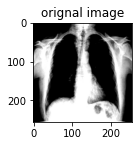

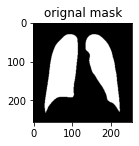

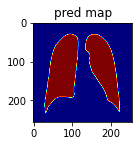

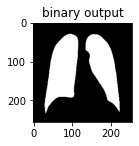

In [17]:
validate()

In [16]:
total_mean

[129.90850553548862, 129.90850553548862, 129.90850553548862]

In [17]:
total_std

[64.48403222822402, 64.48403222822402, 64.48403222822402]

In [13]:
import pytorch_model_summary as pms

In [14]:
model = Unet(3,1)

In [16]:
print(pms.summary(model, torch.zeros((32, 3, 256, 256)), show_input=True, show_hierarchical=True))

-------------------------------------------------------------------------------------------------
       Layer (type)                                  Input Shape         Param #     Tr. Param #
       DoubleConv-1                            [32, 3, 256, 256]          38,976          38,976
       DownSample-2                           [32, 64, 256, 256]               0               0
       DoubleConv-3                           [32, 64, 128, 128]         221,952         221,952
       DownSample-4                          [32, 128, 128, 128]               0               0
       DoubleConv-5                            [32, 128, 64, 64]         886,272         886,272
       DownSample-6                            [32, 256, 64, 64]               0               0
       DoubleConv-7                            [32, 256, 32, 32]       3,542,016       3,542,016
       DownSample-8                            [32, 512, 32, 32]               0               0
       DoubleConv-9          